In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, plot_violin, accuracy_perumtations, 
    age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test, deconfound,
    fit_deconfound_model, 
)

/tmp/ipykernel_3091410/1906872101.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Fri Mar 31 08:09:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 27%   27C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# TODO: 
# mail denis
# mail joschka
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?

In [4]:
#work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/jovyan/'
#work_dir = '/home/lukas/Code/brain_age/'

In [5]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence, cv
#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval

#exp = '2023-02-07T06:28:03.373666' # TCN exluding recs with age divergence, subject-wise cv
#exp = '2023-02-09T09:34:21.685021' # TCN exluding recs with age divergence, subject-wise fe 


#exp = '2023-02-10T23:14:51.938016'  # mixed patho and non-patho data
#exp = '2023-02-11T09:11:11.990975'  # subset non-patho, match patho and non-patho dists
#exp = '2023-02-11T09:11:23.883557'  # subset non-patho, uniform patho and non-patho dists

exp = '2023-02-15T18:59:11.767923'  # cv
exp = '2023-02-15T18:43:26.819382'  # fe

#exp = '2023-02-22T12:51:02.928667'

exp_dir = os.path.join(base_dir, exp)

In [6]:
configs = read_result(exp_dir, 'config')

In [7]:
configs

,augment,batch_size,data_path,date,debug,fast_mode,final_eval,intuitive_training_scores,loss,max_age,...,standardize_data,standardize_targets,subsample,subset,target_name,tmin,tmax,valid_set_i,window_size_samples,run_name
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age
0,dropout,128,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2023-02-15T18:43:26.819382,1,1,1,1,mae,-1,...,1,1,0,normal,age,60,-1,0,6000,decode_age


In [8]:
configs.iloc[0]

augment                                                                dropout
batch_size                                                                 128
data_path                    /home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...
date                                                2023-02-15T18:43:26.819382
debug                                                                        1
fast_mode                                                                    1
final_eval                                                                   1
intuitive_training_scores                                                    1
loss                                                                       mae
max_age                                                                     -1
min_age                                                                     -1
model_name                                                                 tcn
n_epochs                                            

In [9]:
assert configs['final_eval'].nunique() == 1

In [10]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed']]

,model_name,target_name,valid_set_i,seed
0,tcn,age,0,20230214
0,tcn,age,0,20230215
0,tcn,age,0,20230216
0,tcn,age,0,20230217
0,tcn,age,0,20230218


In [11]:
scores = read_result(exp_dir, 'score')

In [12]:
score = 'mae'  # mae, mpe, r2
if (configs['final_eval'] == '1').all():
    display(scores.loc[[score]].mean())
else:
    display(scores.loc[[score]].groupby('seed').mean())

train                              2.676739e+00
eval                               6.517127e+00
eval_not_normal                    1.341554e+01
transition                         1.177079e+01
non_pathological                   1.337067e+01
pathological                       1.625009e+01
transition_long                    1.169707e+01
non_pathological_long              1.202639e+01
pathological_long                  1.579273e+01
transition_long_clean_age          1.212099e+01
non_pathological_long_clean_age    1.181561e+01
pathological_long_clean_age        1.563892e+01
seed                               2.023022e+07
valid_set_i                        0.000000e+00
dtype: float64

In [13]:
histories = read_result(exp_dir, 'history')

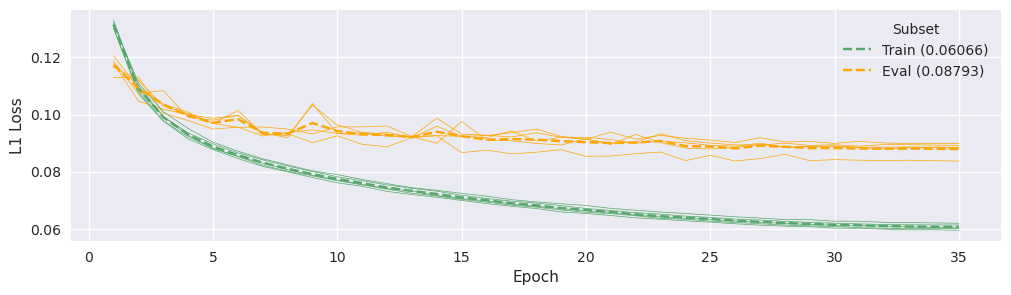

In [14]:
if (configs['final_eval'] == '1').all():
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], 'L1 Loss', 'Eval')
    ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], 'L1 Loss')
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')

In [15]:
preds = read_result(exp_dir, 'preds')

In [16]:
accs = []
for n1, g1 in preds.groupby('seed'):
    acc = balanced_accuracy_score(g1.y_true.to_numpy().astype(int), g1.y_pred.to_numpy().astype(int))
    accs.append(acc)
mean_acc = np.mean(accs)
print(f'avg acc over {preds.seed.nunique()} seeds with {preds.valid_set_i.nunique()} folds', mean_acc)

avg acc over 5 seeds with 1 folds 0.03667891856571101


In [17]:
subject_wise = True

In [18]:
def heatmaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)]
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean(numeric_only=True)
        if subject_wise:
            g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
        if detrend is not None:
            model = fit_deconfound_model(
                g1[g1.pathological == False].y_true, 
                g1[g1.pathological == False].y_pred, 
                detrend,
            )
            g1['y_pred'] = g1.y_pred - model(g1.y_true)
        """
        g1 = deconfound(g1, detrend)
        """
        ax = plot_heatmaps(g1, bin_width)#, 100, hist_max_count=12)
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = g1[g1.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            if subject_wise:
                g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
            if detrend is not None:
                model = fit_deconfound_model(
                    g1[g1.pathological == False].y_true, 
                    g1[g1.pathological == False].y_pred, 
                    detrend,
                )
                g1['y_pred'] = g1.y_pred - model(g1.y_true)
            """
            g1 = deconfound(g1, detrend)
            """
            ax = plot_heatmaps(g1, bin_width)#, 100, hist_max_count=100)
    return ax

In [19]:
def gaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean(numeric_only=True)
        if subject_wise:
            g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
        if detrend is not None:
            model = fit_deconfound_model(
                g1[g1.pathological == False].y_true, 
                g1[g1.pathological == False].y_pred, 
                detrend,
            )
            g1['y_pred'] = g1.y_pred - model(g1.y_true)
        """
        g1 = deconfound(g1, detrend)
        """
        ax = plot_age_gap_hist_and_permutation_test(
            g1, bin_width, n_repetitions,
        )
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = preds[preds.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            if subject_wise:
                g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
            if detrend is not None:
                model = fit_deconfound_model(
                    g1[g1.pathological == False].y_true, 
                    g1[g1.pathological == False].y_pred, 
                    detrend,
                )
                g1['y_pred'] = g1.y_pred - model(g1.y_true)
            """
            g1 = deconfound(g1, detrend)
            """
            ax = plot_age_gap_hist_and_permutation_test(
                g1, bin_width, n_repetitions,
            )
    return ax

In [20]:
def proxy(preds, configs, sex, min_age, max_age, cols, detrend, bin_width, thresh1=None, thresh2=None):
    if (configs['final_eval'] == '1').all():
        g1 = preds[preds.gender==sex] if sex is not None else preds
        g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
        g1 = g1.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean(numeric_only=True)
        if subject_wise:
            g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
        if detrend is not None:
            model = fit_deconfound_model(
                g1[g1.pathological == False].y_true, 
                g1[g1.pathological == False].y_pred, 
                detrend,
            )
            g1['y_pred'] = g1.y_pred - model(g1.y_true)
        """
        g1 = deconfound(g1, detrend)
        """
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            g1, bin_width, n_repetitions, thresh1, thresh2,
        )
    else:
        for n1, g1 in preds.groupby('seed'):
            g1 = preds[preds.gender==sex] if sex is not None else g1
            g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
            if subject_wise:
                g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
            if detrend is not None:
                model = fit_deconfound_model(
                    g1[g1.pathological == False].y_true, 
                    g1[g1.pathological == False].y_pred, 
                    detrend,
                )
                g1['y_pred'] = g1.y_pred - model(g1.y_true)
            """
            g1 = deconfound(g1, detrend)
            """
            ax = plot_age_gap_hist_with_thresh_and_permutation_test(
                g1, bin_width, n_repetitions,
            )
    return ax

In [21]:
bin_width = 2
n_repetitions = 100  # ! actually 100000 !
cols = ['y_pred', 'y_true', 'pathological', 'subject', 'index', 'subset']

In [22]:
if n_repetitions != 100000:
    print("WARNING! Wrong number of reps!")

WARNING! Wrong number of reps!


In [23]:
save = False
age_limits = [(None, 30), (30, 60), (60, None)]  #[(None, 30), (30, 60), (60, None)]#
sexes = [None]#['F', 'M'] #[None]#
detrends = ['quadratic']  # None, linear, quadratic
# extracted from cv
thresh1 = -8.786315726356626 if (configs['final_eval'] == '1').all() else None 
thresh2 = 4.877341101987973 if (configs['final_eval'] == '1').all() else None
#thresh1 = None
#thresh2 = None

Thu Mar 23 14:56:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 56%   57C    P2    76W / 250W |   2085MiB / 11264MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

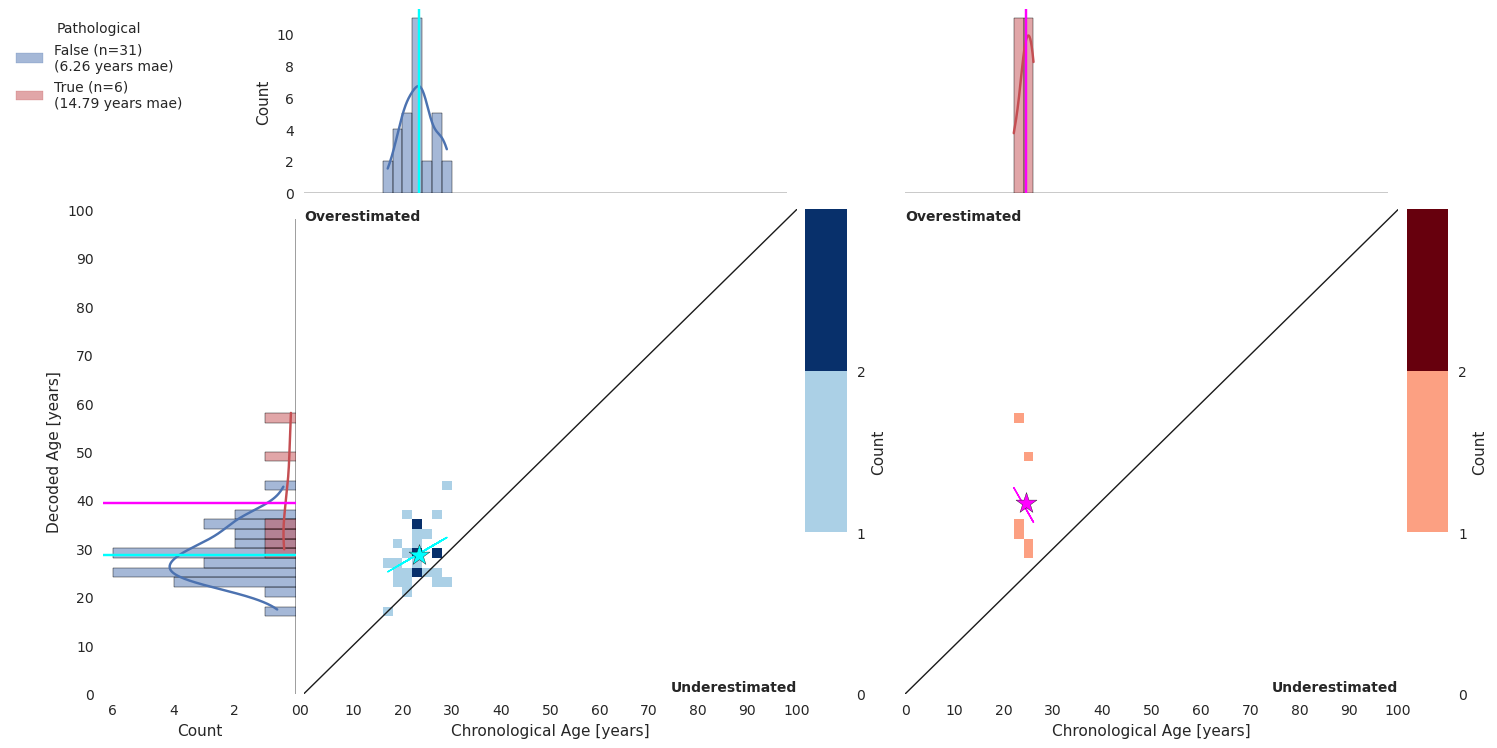

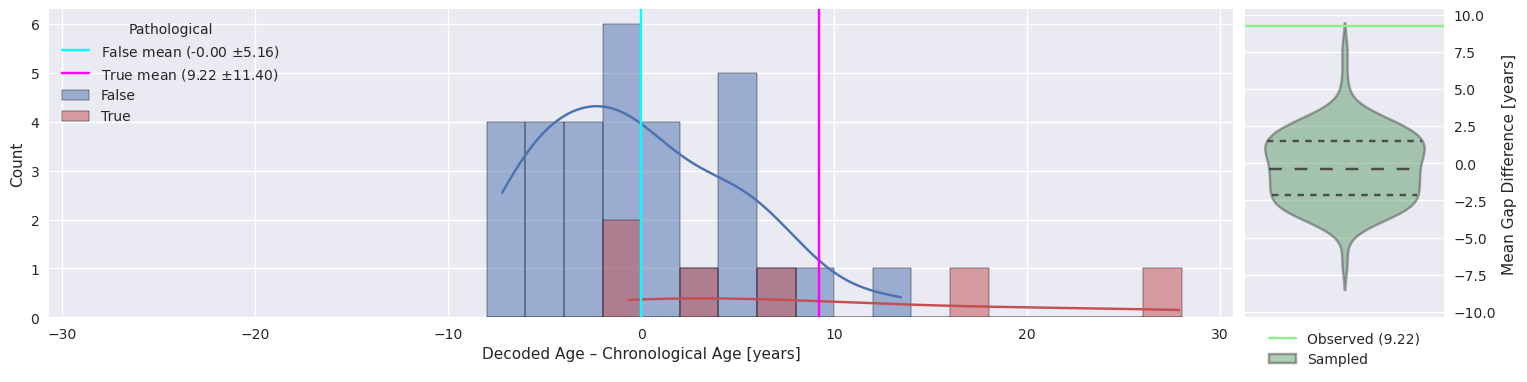

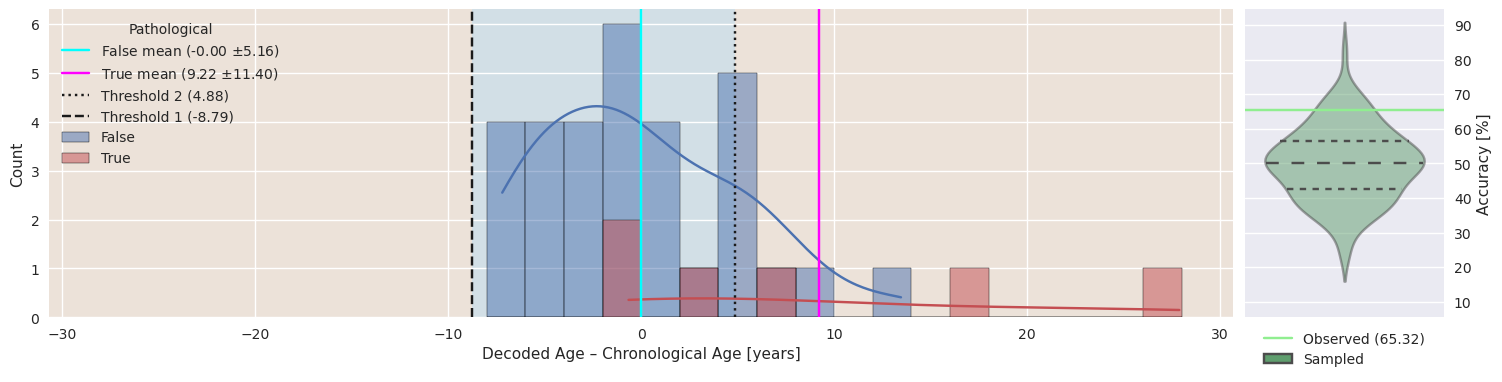

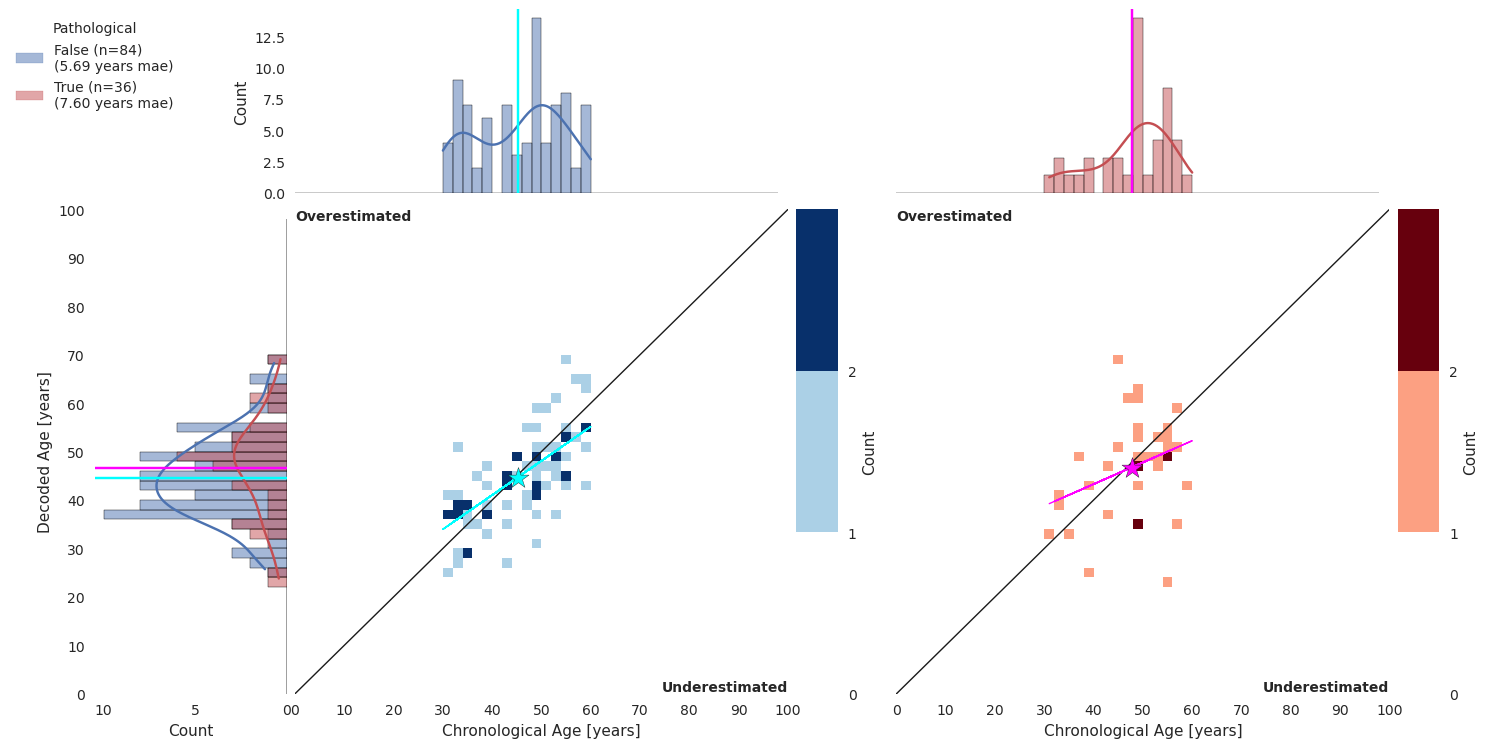

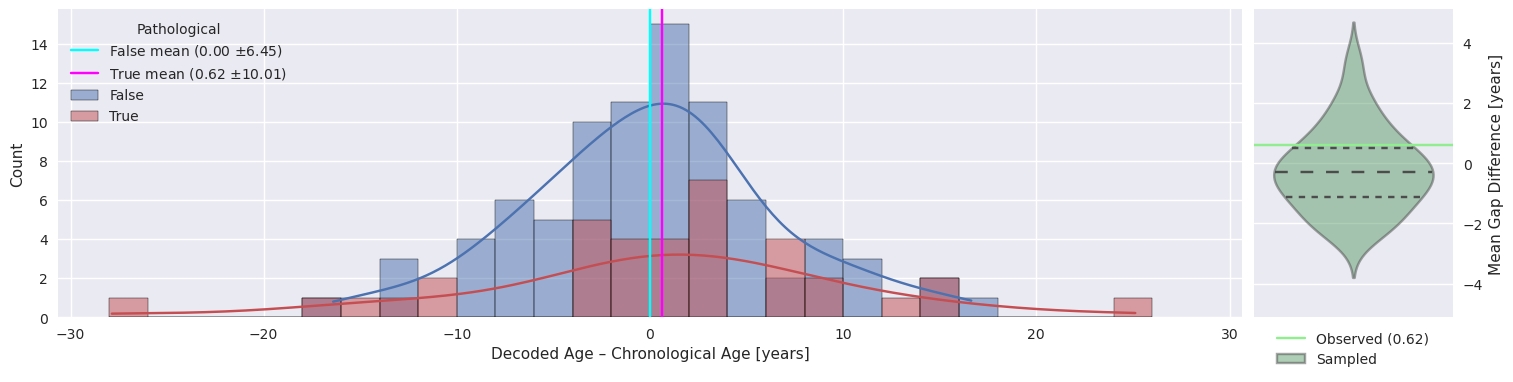

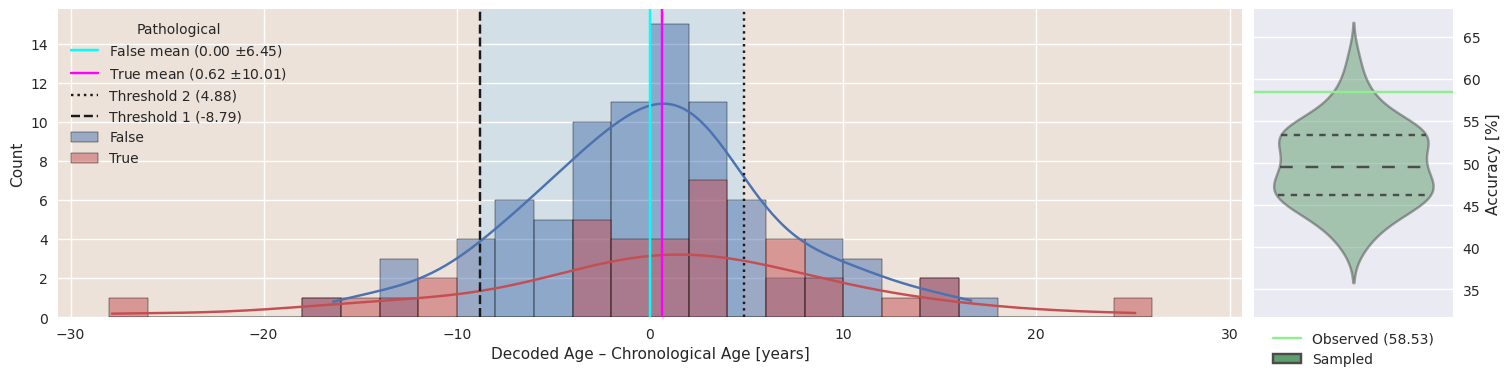

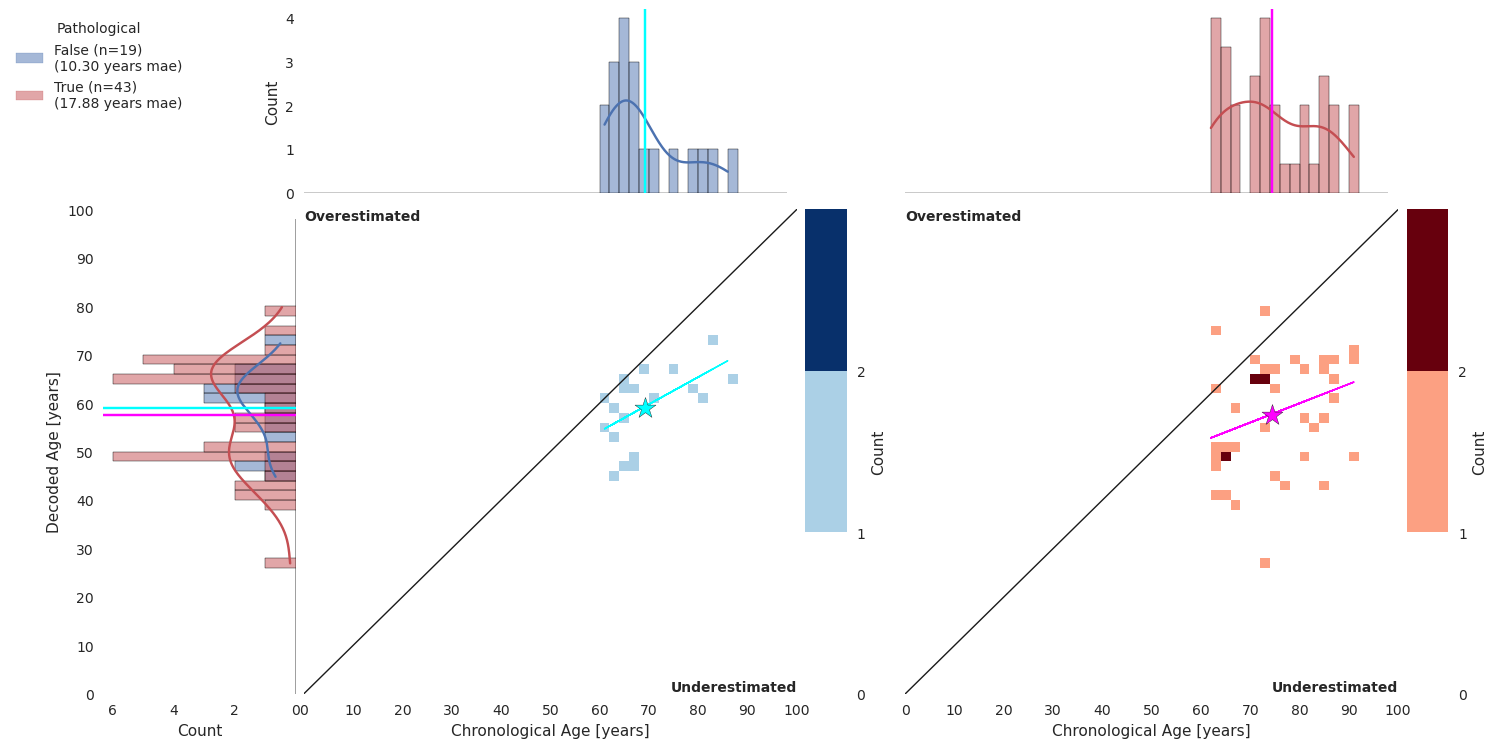

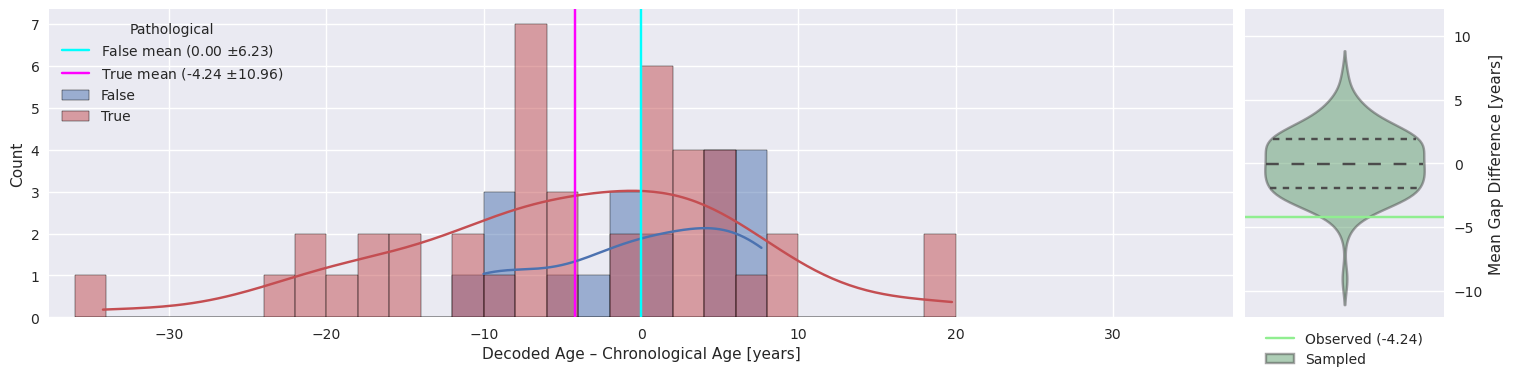

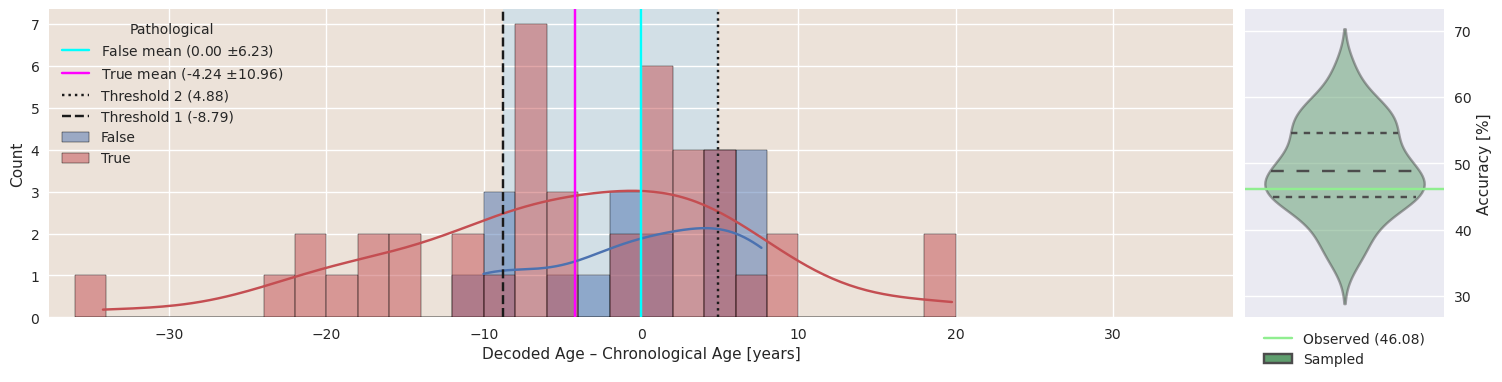

In [30]:
for (min_age, max_age) in age_limits:
    for sex in sexes:
        for detrend in detrends:
            max_age = preds.age.max() if max_age is None else max_age
            min_age = preds.age.min() if min_age is None else min_age
            print(min_age, max_age, sex, detrend, thresh1, thresh2)
            # actual predictions can never be detrended as this would be cheating
            ax = heatmaps(preds, configs, sex, min_age, max_age, cols, None, bin_width)
            if save:
                ax.get_figure().savefig('/home/jovyan/eval_heatmaps.jpg', bbox_inches='tight', dpi=300)
            #ax = gaps(preds, configs, sex, min_age, max_age, cols, None, bin_width)
            ax = gaps(preds, configs, sex, min_age, max_age, cols, detrend, bin_width)
            if save:
                ax.get_figure().savefig('/home/jovyan/eval_gaps.jpg', bbox_inches='tight', dpi=300)
            ax = proxy(preds, configs, sex, min_age, max_age, cols, detrend, bin_width, thresh1, thresh2)
            if save:
                ax.get_figure().savefig('/home/jovyan/eval_proxy.jpg', bbox_inches='tight', dpi=300)

In [65]:
model = fit_deconfound_model(preds.y_true, preds.y_pred, 'linear')

In [66]:
preds.y_pred - model(preds.y_true)

0      36.493414
1      43.840008
2      39.115610
3      38.386027
4      32.234675
         ...    
101    26.140277
102    37.948827
103    23.657416
104    44.857129
105    46.336879
Length: 1215, dtype: float64

In [87]:
model = fit_deconfound_model(g1[g1.pathological == False].y_true, 
                             g1[g1.pathological == False].y_pred, 'linear')

In [88]:
g1.y_pred - model(g1.y_true)

0      35.011880
1      43.535131
2      42.005782
3      35.206030
4      30.948266
         ...    
101    33.201082
102    36.243225
103    30.718220
104    46.398344
105    43.170209
Length: 243, dtype: float64

In [6]:
import re

import mne

from decode_tueg import (
    deconfound, plot_age_gap_hist_and_permutation_test, 
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test,
    mean_abs_running_diff_of_mean_corrected_gaps, _reject_derivating_ages,
    plot_mean_abs_running_diff_of_mean_corrected_gaps,
)

In [7]:
def get_longitudinal_preds(ds_name, min_mins=None, clean_age=False):
    preds = read_result(exp_dir, f'longitudinal_{ds_name}')
    preds['path'] = [p.replace('/data/datasets/TUH/EEG/', '/home/jovyan/mne_data/TUH/') for p in preds.path]
    #preds.shape, preds.subject.nunique()

    if clean_age:
        #assert min_mins is not None
        gs = []
        for p, g in preds.groupby('path'):
            raw = mne.io.read_raw_edf(p, verbose='error')
            rec_year = raw.info['meas_date'].year
            # seems like one (?) header broke in preprocessing. read header of original unpreprocessed reocrding
            header = TUHAbnormal._read_edf_header(p)
            pattern = r'\d\d-\w\w\w-(\d\d\d\d)'
            matches = re.findall(pattern, str(header))
            if len(matches) != 1:
                birthyear = np.nan
            else:
                birthyear = int(matches[0])
            g['date_age'] = int(rec_year) - birthyear

            pattern = r'(\d+)[ -]+?[years]{3,5}[ -]+?[old]{3}'
            # is this also fine? also finds 33 y.o. often used in old reports
            #pattern = r'(\d+)[ -]+?[years]{1,5}[ -.]+?[old]{1,3}[ .]+?'  
            matches = re.findall(pattern, g.iloc[0].report)
            if len(matches) >= 1:
                # assume report always starts with 'XX year old ...'
                match = int(matches[0])
            elif len(matches) == 0:
                match = np.nan
            g['report_age'] = match
            gs.append(g)
        gs = pd.concat(gs).reset_index()
        gs.shape, gs.subject.nunique()

        preds = gs

        ids = _reject_derivating_ages(preds)
        preds = preds.iloc[ids]
        preds = preds.set_index('index')
        preds.shape, preds.subject.nunique()

    gs = []
    for seed, group in preds.groupby('seed'):
        group['duration'] = group.n_samples / group.sfreq
        if min_mins is not None:
            group = group[group.duration >= min_mins*60]
        # for eacht subject, there have to be at least two recs still after min duration selection
        for subject, g in group.groupby('subject'):
            if len(g) >= 2:
                # if this is transition, we require both pathologies
                if 'transition' in ds_name and g.pathological.nunique() != 2:
                    continue
                gs.append(g)
    gs = pd.concat(gs)
    return gs

In [8]:
def get_01_10_transitions(preds):
    gs_01, gs_10 = [], []
    for n, g in preds.groupby('subject'):
        #if len(g) == 2:
        if g.pathological.diff().sum() > 0:
            gs_10.append(g)
        elif g.pathological.diff().sum() < 0:
                gs_01.append(g)
        else:
            assert g.pathological.diff().sum() == 0
            #print(n)
    if gs_01:
        gs_01 = pd.concat(gs_01)
    if gs_10:
        gs_10 = pd.concat(gs_10)
    return gs_01, gs_10

In [9]:
def counts(preds):
    rec_preds = preds.copy()
    print(f'{len(rec_preds)} recs of {rec_preds.subject.nunique()} subjects')
    for seed, group in rec_preds.groupby('seed'):
        break
    print(f'{len(group)} recs of {group.subject.nunique()} subjects')
    print(f"thereof female {group.groupby('subject').head(1).gender.value_counts()}")

In [11]:
ds_name = 'transition'
min_mins = 15
clean_age = True

In [12]:
rec_preds = get_longitudinal_preds(ds_name, min_mins, clean_age)

In [13]:
rec_preds.gender.unique()

array(['M', 'F'], dtype=object)

In [14]:
assert sorted(rec_preds.gender.unique()) == ['F', 'M']
rec_preds['gender'] = rec_preds.gender == 'F'

In [15]:
counts(rec_preds)

2800 recs of 221 subjects
560 recs of 221 subjects
thereof female True     119
False    102
Name: gender, dtype: int64


In [16]:
# average over seeds / runs, subject, subset, and pathology status. removes gender column. maybe cast beforehand
subj_preds = rec_preds.groupby(['subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)

In [17]:
counts(subj_preds)

442 recs of 221 subjects
442 recs of 221 subjects
thereof female 1.0    119
0.0    102
Name: gender, dtype: int64


In [18]:
bin_size = 2
n_repetitions = 100
detrend = 'quadratic'
thresh1 = -8.786315726356626 
thresh2 = 4.877341101987973 

<AxesSubplot: xlabel=' ', ylabel='Count'>

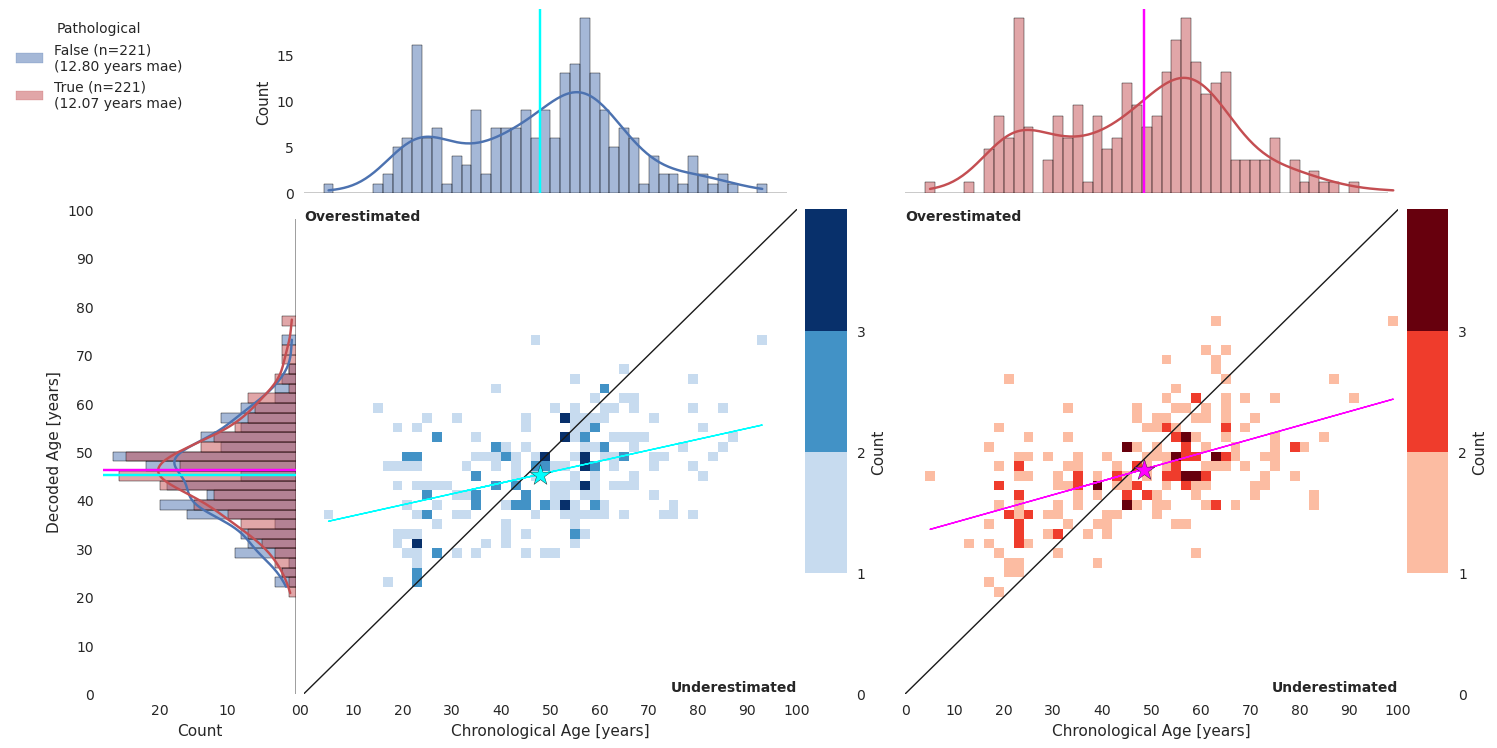

In [19]:
#plot_heatmaps(rec_preds, bin_size)
plot_heatmaps(subj_preds, bin_size)

1470 recs of 120 subjects
294 recs of 120 subjects
thereof female True     66
False    54
Name: gender, dtype: int64
910 recs of 78 subjects
182 recs of 78 subjects
thereof female True     42
False    36
Name: gender, dtype: int64


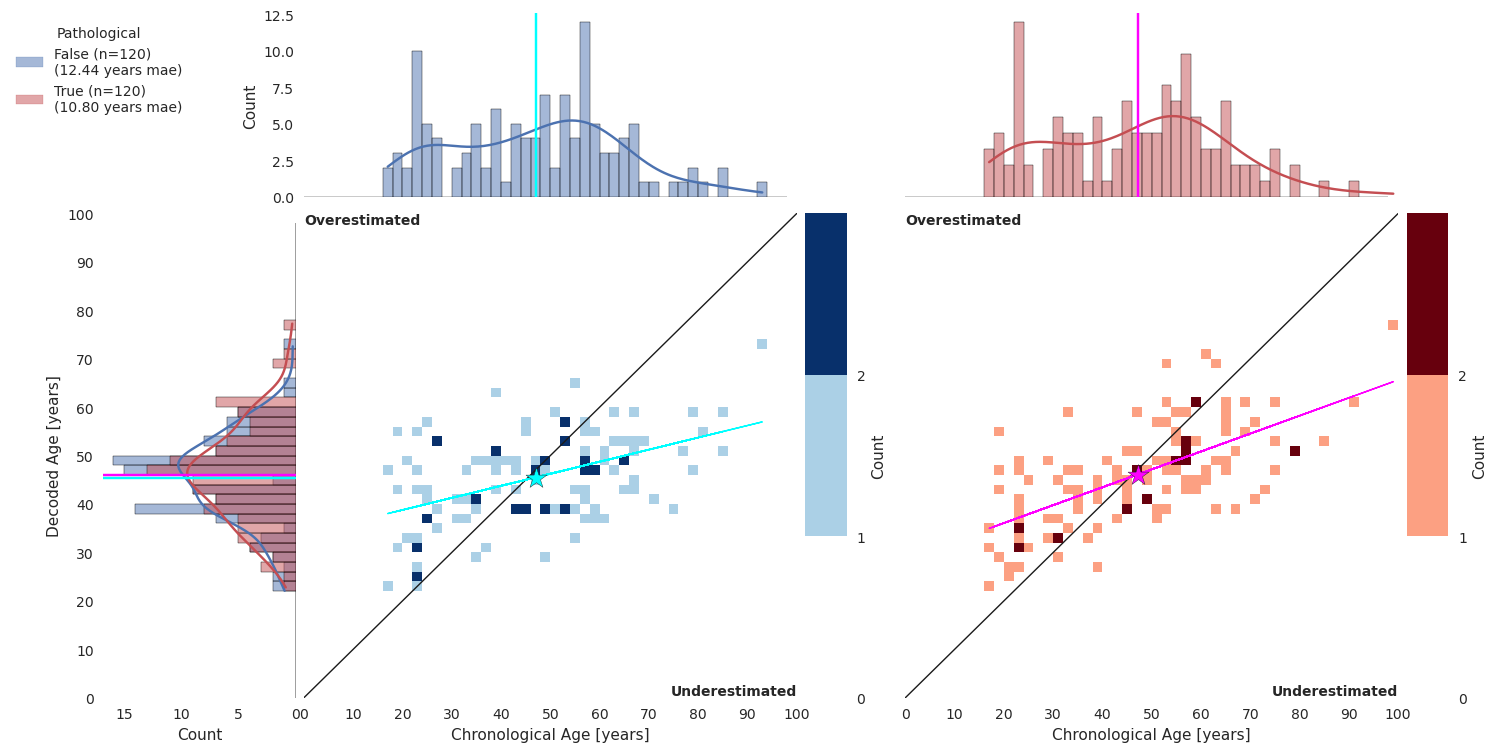

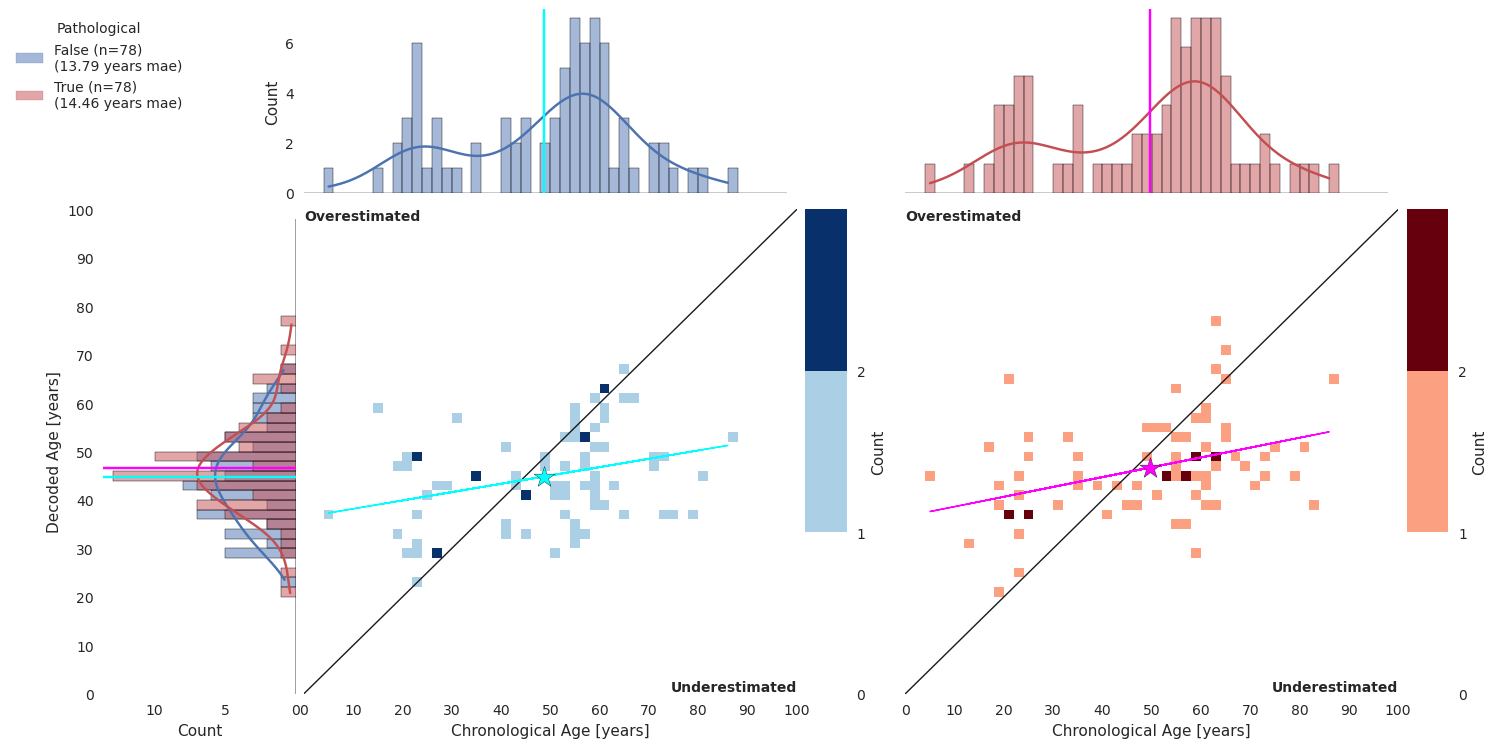

In [20]:
if ds_name.startswith('transition'):
    gs_01, gs_10 = get_01_10_transitions(rec_preds)
    counts(gs_01)
    counts(gs_10)

    # average over runs / seeds
    gs_01_subj = gs_01.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)
    gs_10_subj = gs_10.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)

    #plot_heatmaps(gs_01, bin_size)
    plot_heatmaps(gs_01_subj, bin_size)
    #plot_heatmaps(gs_10, bin_size)
    plot_heatmaps(gs_10_subj, bin_size)

# deconfound predictions

In [21]:
rec_preds = deconfound(rec_preds, detrend)

In [22]:
subj_preds = deconfound(subj_preds, detrend)

In [23]:
if ds_name.startswith('transition'):
    gs_01 = deconfound(gs_01, detrend)
    gs_10 = deconfound(gs_10, detrend)
    gs_01_subj = deconfound(gs_01_subj, detrend)
    gs_10_subj = deconfound(gs_10_subj, detrend)

# all transitions

observed age gap diff 0.8768033635020718
given thresholds -8.786315726356626 4.877341101987973
observed score 47.05882352941176


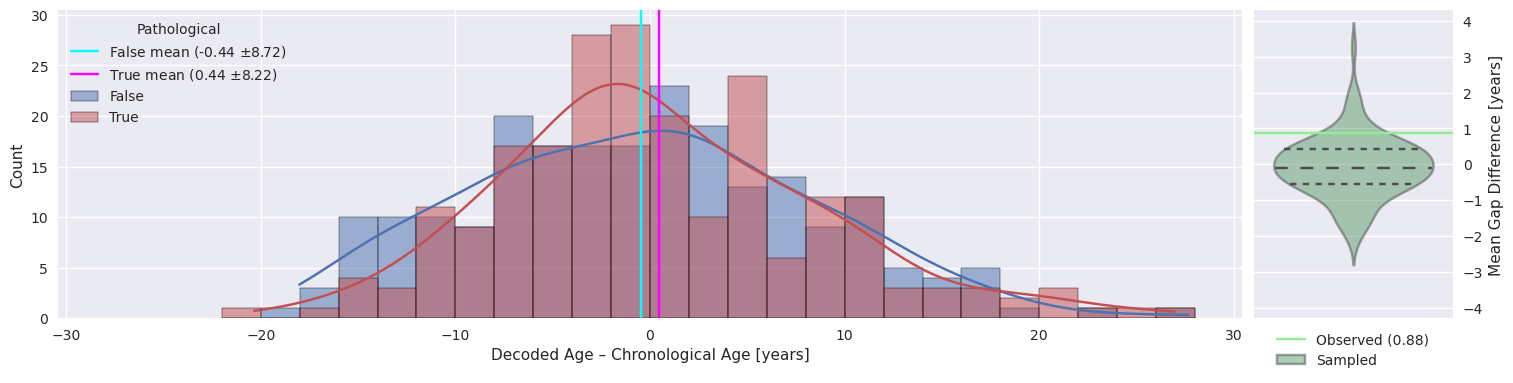

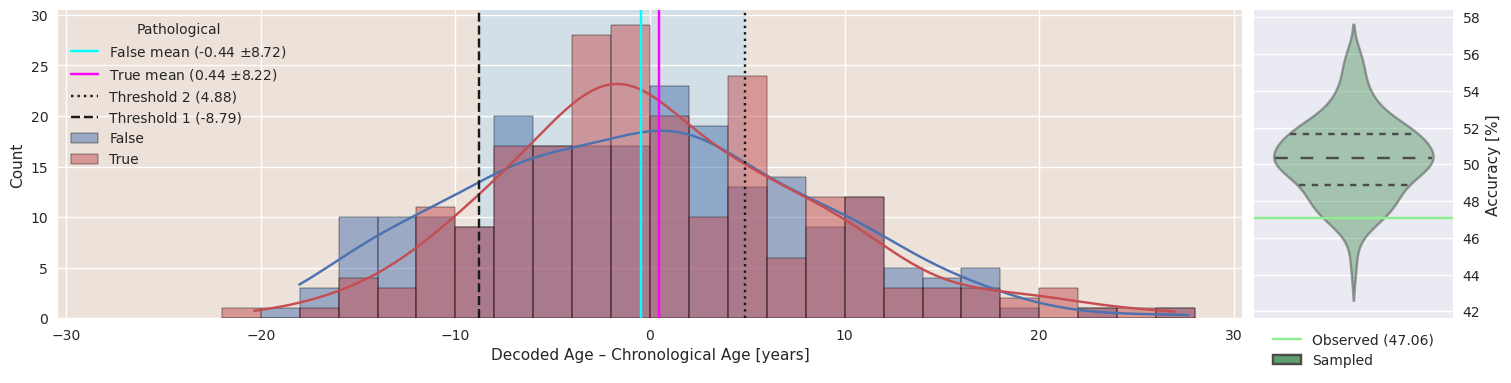

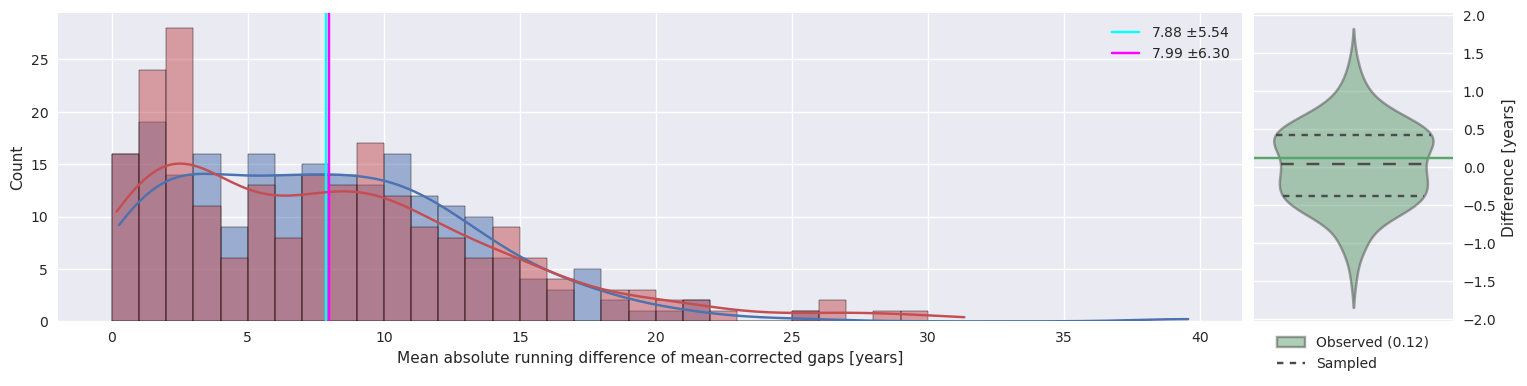

In [24]:
if ds_name.startswith('transition'):
    plot_age_gap_hist_and_permutation_test(subj_preds, bin_size, n_repetitions)
    plot_age_gap_hist_with_thresh_and_permutation_test(
        subj_preds,
        bin_size,
        n_repetitions,
        thresh1,
        thresh2,
    )
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
        mean_abs_running_diff_of_mean_corrected_gaps(rec_preds), 
        n_repetitions,
    )
else:
    plot_age_gap_hist(subj_preds, bin_size)
    plot_mean_abs_running_diff_of_mean_corrected_gaps(
        mean_abs_running_diff_of_mean_corrected_gaps(rec_preds), 
    )

# 01 transitions

observed age gap diff 0.4859315786770761
given thresholds -8.786315726356626 4.877341101987973
observed score 47.916666666666664


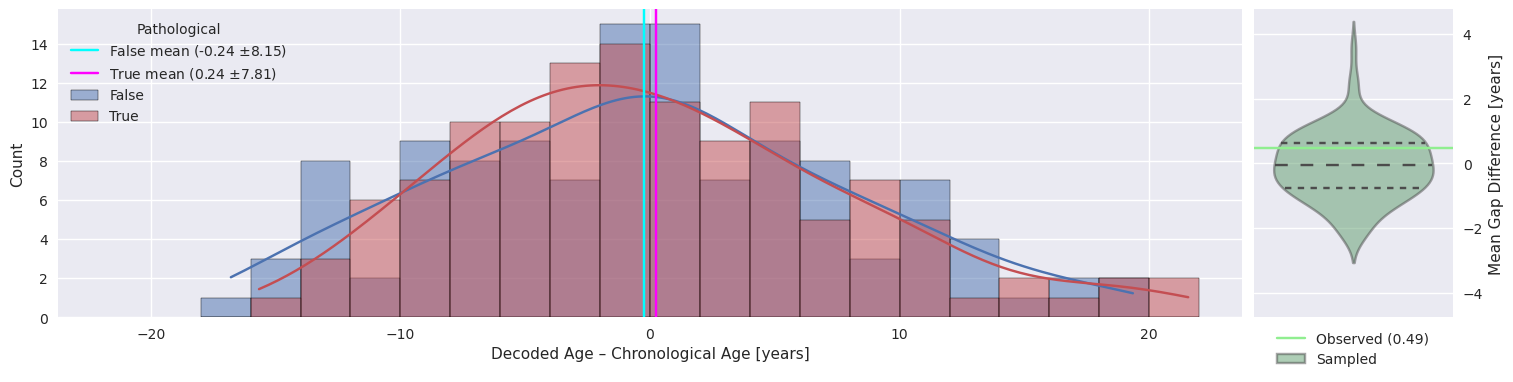

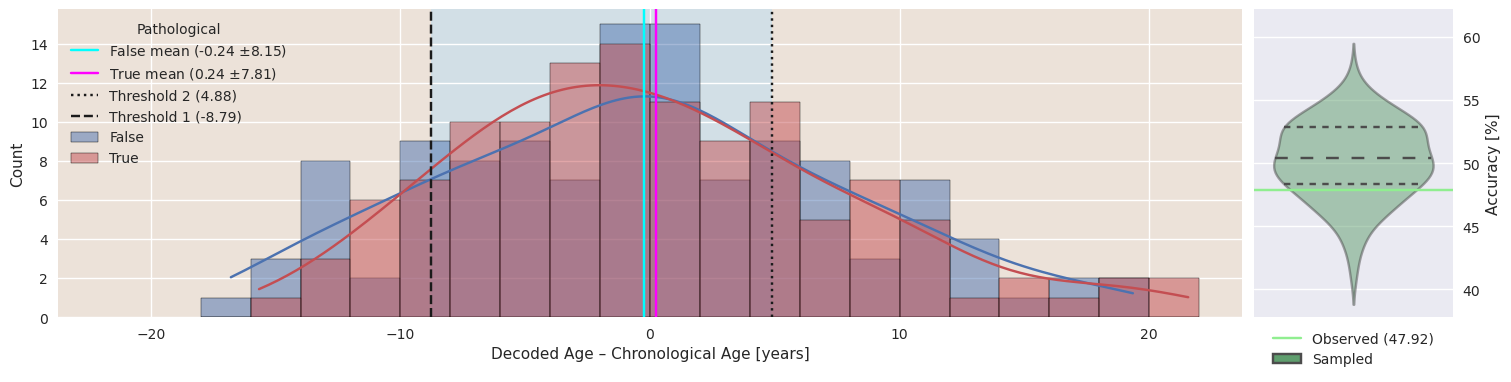

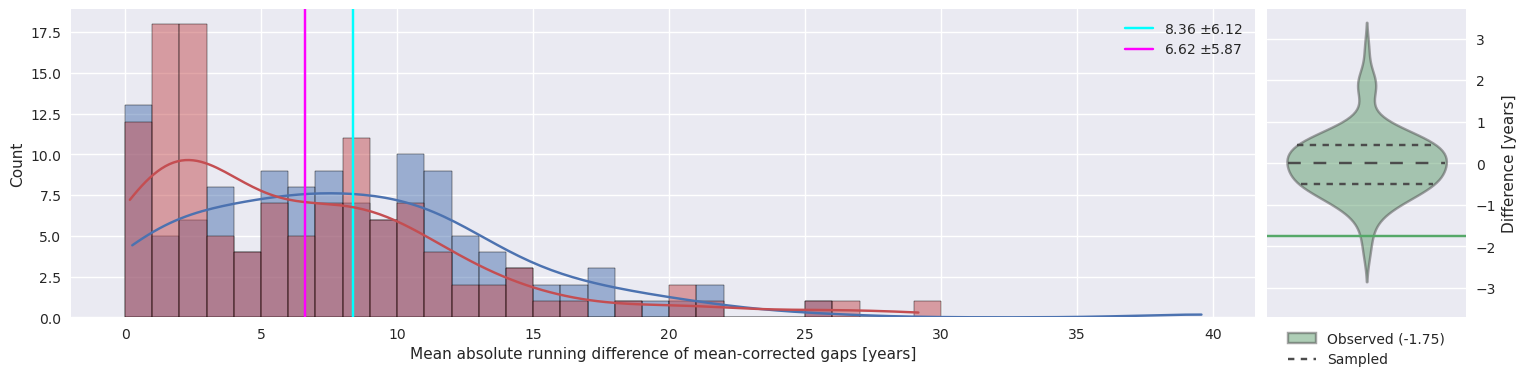

In [25]:
if ds_name.startswith('transition'):
    plot_age_gap_hist_and_permutation_test(gs_01_subj, bin_size, n_repetitions)
    plot_age_gap_hist_with_thresh_and_permutation_test(
        gs_01_subj,
        bin_size,
        n_repetitions,
        thresh1,
        thresh2,
    )
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
        mean_abs_running_diff_of_mean_corrected_gaps(gs_01), 
        n_repetitions,
    )

# 10 transitions

observed age gap diff 1.6610715639007043
given thresholds -8.786315726356626 4.877341101987973
observed score 42.30769230769231


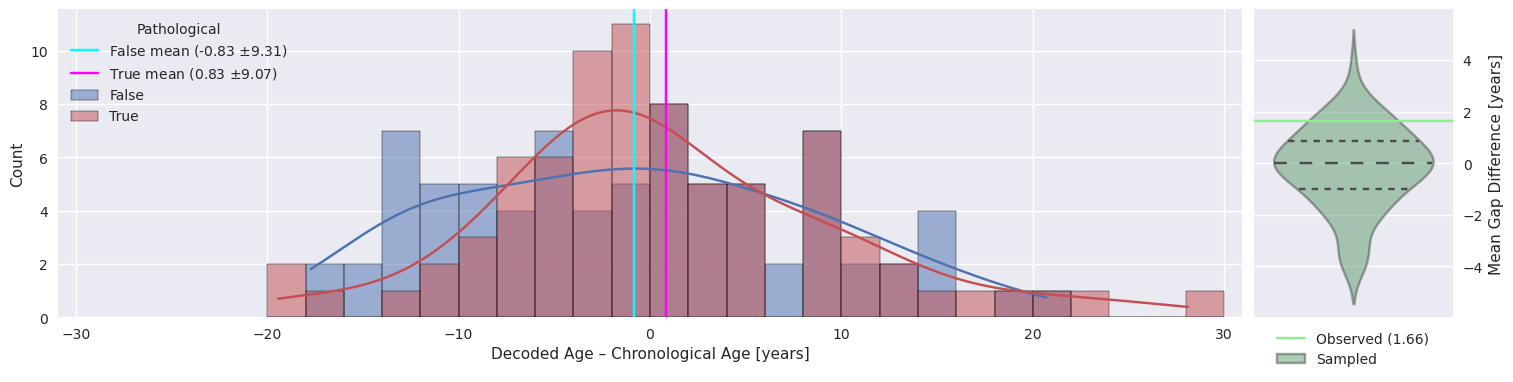

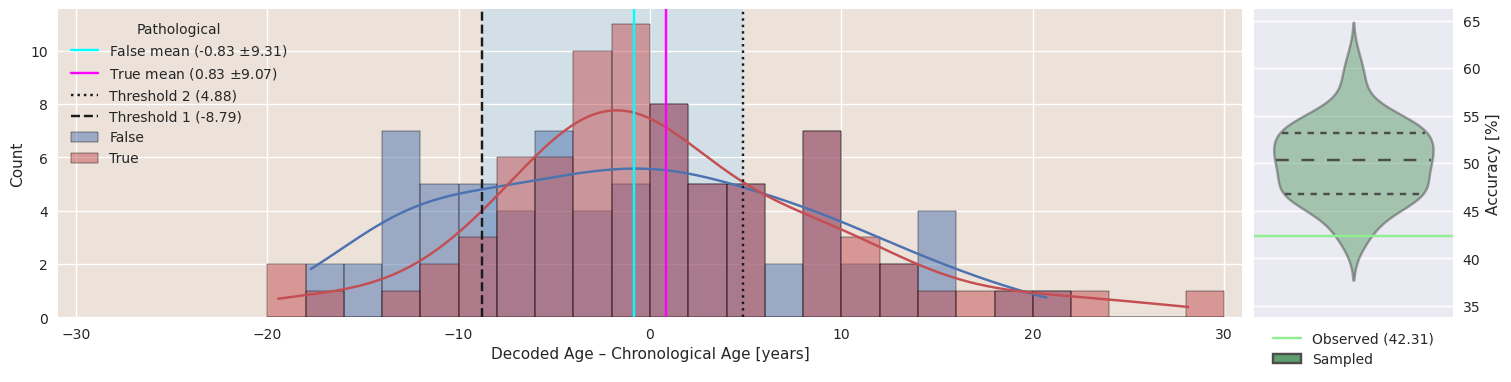

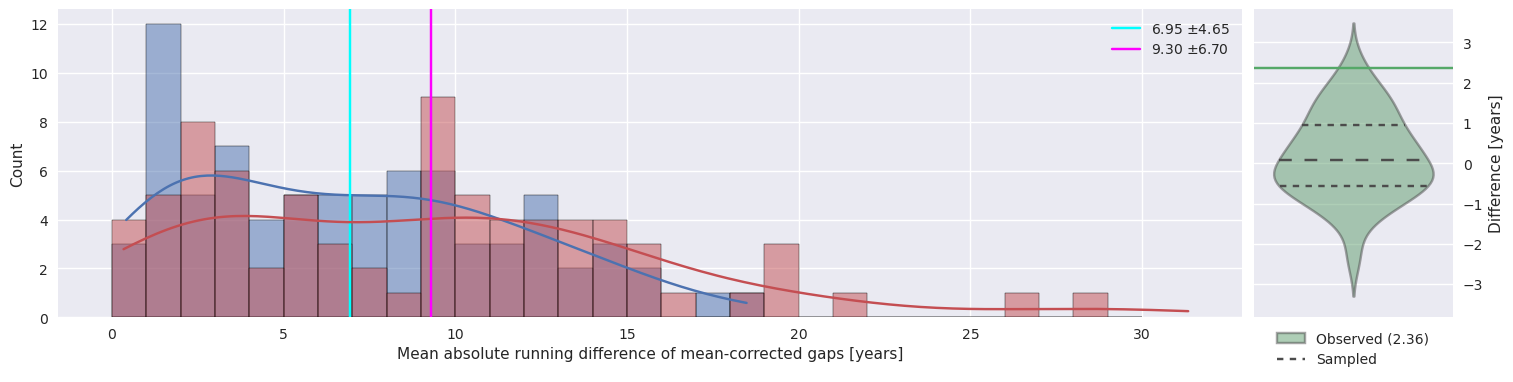

In [26]:
if ds_name.startswith('transition'):
    plot_age_gap_hist_and_permutation_test(gs_10_subj, bin_size, n_repetitions)
    plot_age_gap_hist_with_thresh_and_permutation_test(
        gs_10_subj,
        bin_size,
        n_repetitions,
        thresh1,
        thresh2,
    )
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
        mean_abs_running_diff_of_mean_corrected_gaps(gs_10), 
        n_repetitions,
    )

# plot recording durations and intervals

In [27]:
all_rec_preds = []
for ds_name in ['non_pathological', 'pathological', 'transition']:
    all_rec_preds.append(get_longitudinal_preds(ds_name, min_mins, clean_age))
    if ds_name == 'non_pathological':
        name = 'Non-pathological' 
    elif ds_name == 'pathological':
        name = 'Pathological'
    else:
        name = 'Transition'
    all_rec_predſ[-1]['Longitudinal'] = name
all_rec_preds = pd.concat(all_rec_preds)

In [28]:
all_rec_preds.shape

Fri Mar 31 08:14:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 27%   27C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

(17970, 27)

In [29]:
(all_rec_preds.n_samples / all_rec_preds.sfreq).max()

76738.0

In [30]:
all_rec_preds.subset.unique()

array(['longitudinal_non_pathological', 'longitudinal_pathological',
       'longitudinal_transition'], dtype=object)

In [31]:
def plot_recording_durations(all_rec_preds, tmax=25, stepsize=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12,3))
    all_rec_preds.duration.clip(upper=tmax*60, inplace=True)
    bins = [t*60 for t in range(2, tmax+1, stepsize)]
    ax = sns.histplot(
        data=all_rec_preds,
        x='duration',
        hue='Longitudinal',
        palette=['b', 'r', 'g'],
        bins=bins,
        multiple='stack',
        alpha=.5,
    )
    tick_bins = [t for t in [2, 5, 10, 15, 20, 25]]
    ax.set_xticks([t*60 for t in tick_bins]);
    ax.set_xticklabels([f'{t}*60' for t in tick_bins]);
    return ax

(840.0, 1569.0)

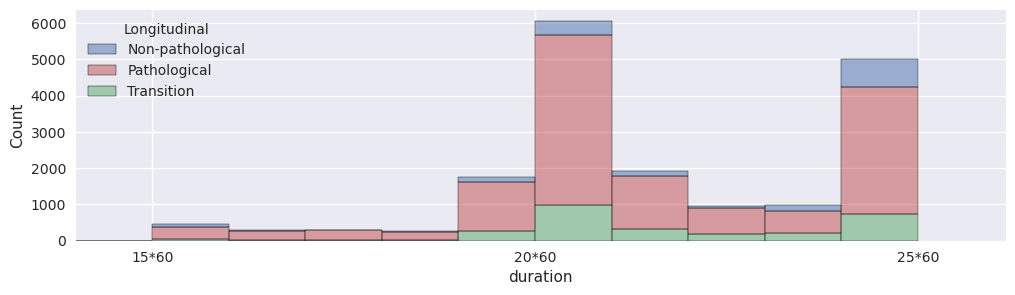

In [37]:
ax = plot_recording_durations(all_rec_preds)
ax.set_xlim((min_mins-1)*60)

In [38]:
from datetime import datetime

In [39]:
from decode_tueg import plot_n_recs_per_subject_and_rec_intervals

In [46]:
# information is there from 5 repetitions of fe. only choose one
all_rec_preds = all_rec_preds[all_rec_preds.seed==20230214]

In [47]:
n_recs_per_subject = all_rec_preds.groupby(['Longitudinal', 'subject'], as_index=False).size()

In [48]:
(n_recs_per_subject.size > 2).all()

True

In [49]:
# sort the dataframe for correct computation of day diffs
all_rec_preds = all_rec_preds.sort_values(['Longitudinal', 'year', 'month', 'day'])

In [50]:
day_diffs = []
for (dataset, subj), group in all_rec_preds.groupby(['Longitudinal','subject']):
    dates = [datetime(y, m, d) for i, (y, m, d) in group[['year', 'month', 'day']].iterrows()]
    for i in range(1, len(dates)):
        day_diffs.append((dataset, (dates[i] - dates[i-1]).days, subj))
day_diffs = pd.DataFrame(day_diffs, columns=['Dataset', 'Interval [days]', 'Subject'])

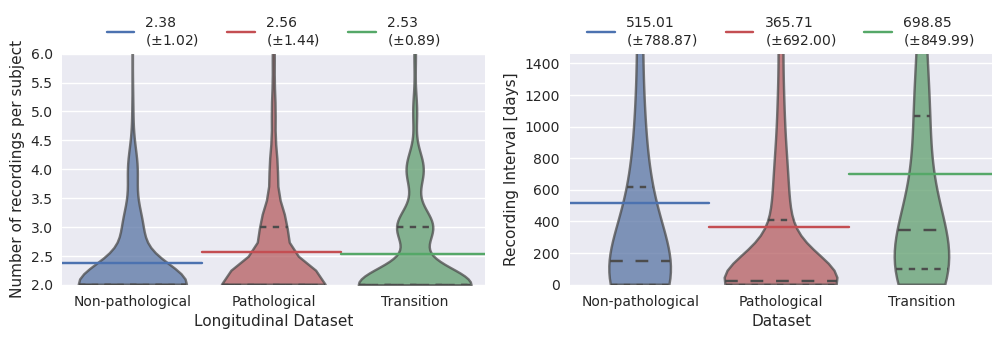

In [51]:
ax_arr = plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, day_diffs)

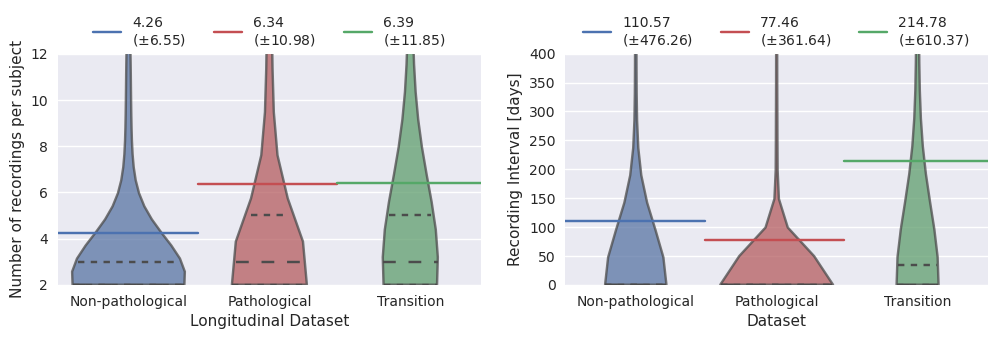

In [471]:
ax_arr[0].set_ylim(2,12)
ax_arr[1].set_ylim(0,400)
ax_arr[0].get_figure()

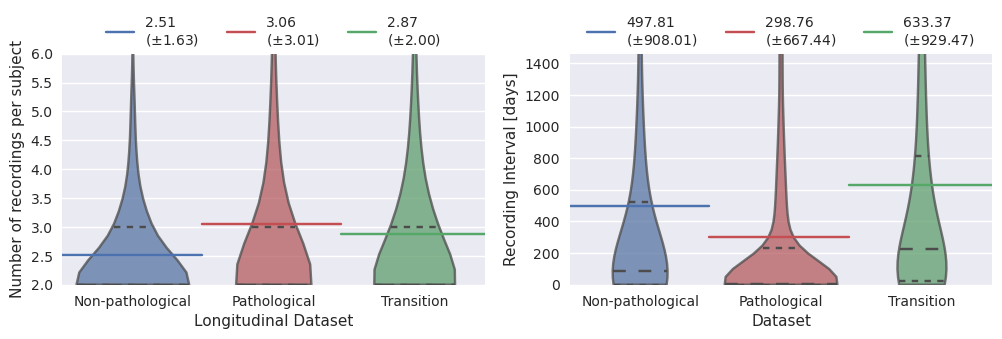

In [452]:
plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, day_diffs)

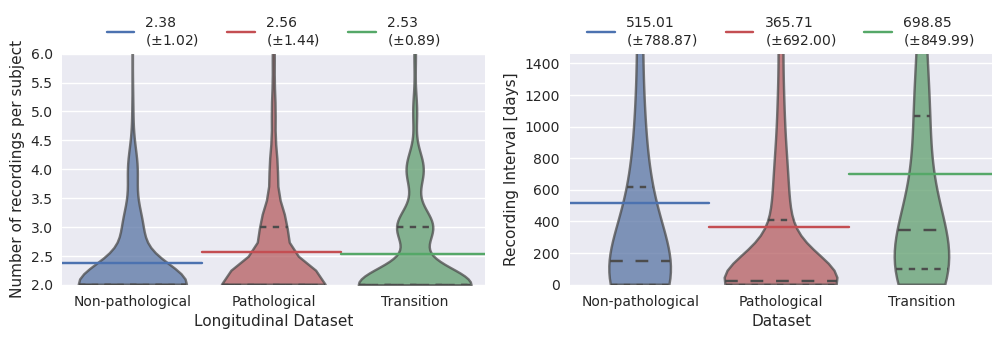

In [431]:
plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, day_diffs)

# look at interesting cases, e.g. very large EEG brain age gap

In [174]:
def find_preds_of_subj_with_biggest_gap(all_rec_preds, ds_name, gap_sign, top):
    if ds_name is not None:
        long_rec_preds = all_rec_preds[all_rec_preds['Longitudinal']==ds_name]
    else:
        long_rec_preds = all_rec_preds
    long_subj_preds = long_rec_preds.groupby(['subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)
    gaps = long_subj_preds.y_pred - long_subj_preds.y_true
    for idx, gap in gaps.sort_values(ascending=gap_sign=='-').head(top).tail(1).items():
        _
    subject = long_subj_preds.iloc[idx].subject
    for seed, group in long_rec_preds[long_rec_preds.subject==subject].groupby('seed'):
        #if seed == 20230216:
            break
    
    return gap, group

In [175]:
ds_name = 'Non-pathological'

In [176]:
gap, group = find_preds_of_subj_with_biggest_gap(all_rec_preds, ds_name, '+', 1)

In [177]:
gap

32.539319947361946

In [178]:
group

,y_true,y_pred,path,version,year,month,day,subject,session,segment,...,dataset,train,IMPRESSION,subset,seed,valid_set_i,date_age,report_age,duration,Longitudinal
index,,,,,,,,,,,,,,,,,,,,,
839,14.0,48.383215,/home/jovyan/mne_data/TUH/tuh_eeg/v1.1.0/edf/0...,v1.1.0,2006,7,31,3412,1,1,...,TUHEEG,True,IMPRESSION: Normal EEG in wakefulness and drow...,longitudinal_non_pathological,20230214,0,14.0,14.0,1175.0,Non-pathological
840,14.0,44.695425,/home/jovyan/mne_data/TUH/tuh_eeg/v1.1.0/edf/0...,v1.1.0,2006,9,5,3412,2,1,...,TUHEEG,True,IMPRESSION: Normal pediatric EEG in wakefulness.,longitudinal_non_pathological,20230214,0,14.0,14.0,1230.0,Non-pathological


In [68]:
long_rec_preds = all_rec_preds[all_rec_preds['Longitudinal']==ds_name]

In [69]:
long_subj_preds = long_rec_preds.groupby(['subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)

In [112]:
(long_subj_preds.y_pred - long_subj_preds.y_true).sort_values().head(1)

20   -36.34205
dtype: float64

In [115]:
(long_subj_preds.y_pred - long_subj_preds.y_true).sort_values().tail(1)

63    32.53932
dtype: float64

In [104]:
long_subj_preds.iloc[(long_subj_preds.y_pred - long_subj_preds.y_true).sort_values().tail(1).index]

,subset,subject,pathological,y_true,y_pred,year,month,day,session,segment,sfreq,n_samples,age,train,seed,valid_set_i,date_age,report_age,duration
63,longitudinal_non_pathological,3412,0,14.0,46.53932,2006.0,8.0,18.0,1.5,1.0,250.0,300625.0,14.0,1.0,20230214.0,0.0,14.0,14.0,1202.5


In [72]:
s = long_subj_preds.iloc[(long_subj_preds.y_pred - long_subj_preds.y_true).argmax()].subject

In [74]:
long_subj_preds[long_subj_preds.subject==s]

,subset,subject,pathological,y_true,y_pred,year,month,day,session,segment,sfreq,n_samples,age,train,seed,valid_set_i,date_age,report_age,duration
63,longitudinal_non_pathological,3412,0,14.0,46.53932,2006.0,8.0,18.0,1.5,1.0,250.0,300625.0,14.0,1.0,20230214.0,0.0,14.0,14.0,1202.5


In [75]:
for seed, group in long_rec_preds[long_rec_preds.subject==s].groupby('seed'):
    #if seed == 20230216:
        break

In [76]:
# TODO: -1 y_true super weird. check what is happening!

In [77]:
group

,y_true,y_pred,path,version,year,month,day,subject,session,segment,...,dataset,train,IMPRESSION,subset,seed,valid_set_i,date_age,report_age,duration,Longitudinal
index,,,,,,,,,,,,,,,,,,,,,
839,14.0,48.383215,/home/jovyan/mne_data/TUH/tuh_eeg/v1.1.0/edf/0...,v1.1.0,2006,7,31,3412,1,1,...,TUHEEG,True,IMPRESSION: Normal EEG in wakefulness and drow...,longitudinal_non_pathological,20230214,0,14.0,14.0,1175.0,Non-pathological
840,14.0,44.695425,/home/jovyan/mne_data/TUH/tuh_eeg/v1.1.0/edf/0...,v1.1.0,2006,9,5,3412,2,1,...,TUHEEG,True,IMPRESSION: Normal pediatric EEG in wakefulness.,longitudinal_non_pathological,20230214,0,14.0,14.0,1230.0,Non-pathological


In [78]:
group.y_pred - group.y_true

index
839    34.383215
840    30.695425
dtype: float64

In [79]:
(group.y_pred - group.y_true).mean()

32.539319947361946

In [80]:
group.y_pred.mean() - group.y_true.mean()

32.539319947361946

In [81]:
for index, (y,m,d,r) in group[['year', 'month', 'day', 'report']].iterrows():
    print(y,m,d)
    print(r.strip())
    print()

2006 7 31
CLINICAL HISTORY: This is a 14-year-old, right-handed male with new onset seizures described as falling out of bed, difficulty breathing with the upper part of the body jumping, eyes rolling back in the head, and foaming at the mouth for one to two minutes.
MEDICATIONS: None.
INTRODUCTION: Digital video EEG is performed in the lab using standard 10-20 system of electrode placement with one channel of EKG. Hyperventilation and photic stimulation were performed.  This is an awake and asleep record.
DESCRIPTION OF THE RECORD: In wakefulness, the background EEG is well organized with a 9 Hz, 40 uV posterior dominant rhythm.  Hyperventilation is performed with good effort, producing an increase in the amplitude of the background.  Following hyperventilation, there are occasional posterior slow waves of youth identified.  Features of drowsiness include rhythmic background theta and anterior spread of the alpha rhythm.  Photic stimulation elicits brief bilateral driving.
HR:  60 to 